In [127]:
import numpy as np
from skimage import io
from skimage import color
from skimage import img_as_ubyte
from skimage import filters
import matplotlib.pyplot as plt
%matplotlib inline

# OPF-APIからのデータ取得

In [2]:
# # 富士山（雪が一番わかりやすいため）
z=13
x=7252
y=3234

# # # クアプラザピリカ スキー場
# z = 13
# x = 7286
# y = 3026

In [3]:
URL_DOMAIN="https://img.opf-dev.jp"
img_types=["osm",
                      "true",
                      "natural",
                      "av2ori/band1",
                      "av2ori/band2",
                      "av2ori/band3",
                      "av2ori/band4"]

urls=["{}/{}/{}/{}/{}.png".format(URL_DOMAIN, img_type, z, x, y) for img_type in img_types]
imgs = np.array([io.imread(url) for url in urls])
img_band1 = imgs[3].copy()
img_band2 = imgs[4].copy()
img_band3 = imgs[5].copy()
img_band4 = imgs[6].copy()

(7, 256, 256, 3)


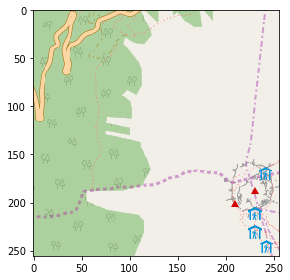

In [65]:
print(imgs.shape)
io.imshow(imgs[0])

Band1 = 青
Band2 = 緑
Band3 = 赤
Band4 = 近赤外線

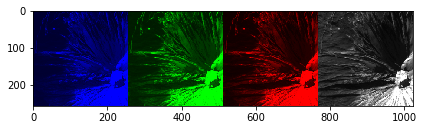

In [6]:
io.imshow(np.hstack((img_band1,img_band2,img_band3,img_band4)))

カラー合成をおこなう場合RGB（赤緑青）で合成するように、赤色にBand3を、緑色にBand2を、青色にBand1を割り当てると可視光線にもっとも近い色が合成可能（これをtrue colorと呼ぶ）。

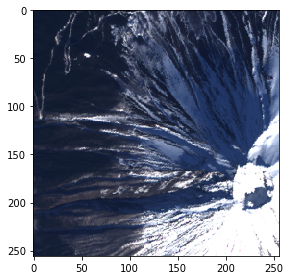

In [8]:
img_true = np.c_[img_band3[:,:,0:1], img_band2[:,:,1:2], img_band1[:,:,2:3]]
io.imshow(img_true)

それ以外にも合成方法は複数あり、例えば植生域だけを際立たせたい時は、植物の分布域が緑で表現されるnatural colorで表現する。近赤外線は植物の反射率が高いことを利用し、緑色に近赤外のBand4を、赤色にBand3を、青色にBand2を割り当てたものが使われる。
Ｒ：Band3（可視赤領域）
Ｇ：Band4（近赤外領域）
Ｂ：Band2（可視緑～黄領域）

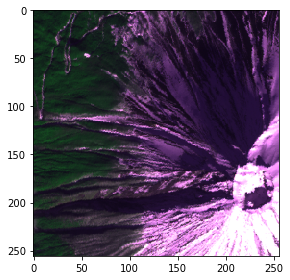

In [9]:
img_natural = np.c_[img_band3[:,:,0:1], img_band4[:,:,0:1], img_band2[:,:,1:2]]
io.imshow(img_natural)

### 直感的に白っぽいところを雪として判別してみる
直感で白っぽいところが雪なのでは？と誰もが思うはずなので、それを試すべく、true画像 -> グレー画像 -> 閾値を決めて白っぽいところだけ抽出し、雪が抽出できるか検証。

### グレー画像作成方法①

`color.rgb2gray` によって直接グレースケール化

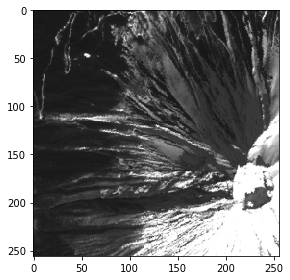

In [19]:
#カラー画像からGrayscale画像への変換
img_gray_01 = color.rgb2gray(img_true)
# 値のレンジを変更(0-1 -> 0-255)
img_gray = img_as_ubyte(img_gray_01) 
io.imshow(img_gray)

### グレー画像作成方法②

一度RGBからYIQ空間へ変換し、Yを利用。YIQ形式は、グレースケール情報がカラーデータから分離しているため、同じ信号をカラーと白黒の両方で使用可能。

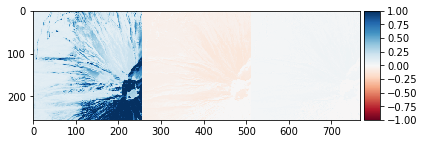

In [21]:
img_yiq = color.rgb2yiq(img_true)
img_conb = np.concatenate((img_yiq[:, :, 0], img_yiq[:, :, 1], img_yiq[:, :, 2]),axis=1)
io.imshow(img_conb)

img_gray_01 と img_yiqの0次元目は一緒

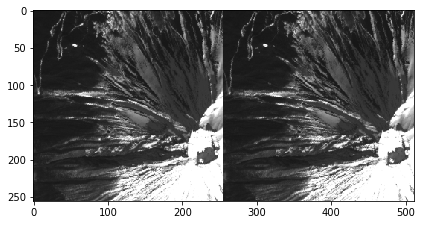

In [23]:
img_conb2 = np.concatenate((img_yiq[:, :, 0], img_gray_01), axis=1)
io.imshow(img_conb2)

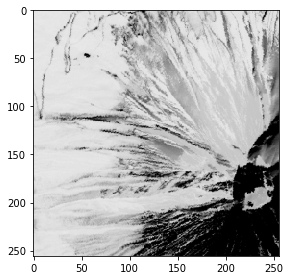

In [31]:
# 反転画像も一応確認
img_nega = 255 - img_gray
io.imshow(img_nega)

## グレー化されたデータの統計情報を確認

In [25]:
print('pixel sum', np.sum(img_gray[:, :]))
print('pixel mean', np.mean(img_gray[:,:]))
print('pixel variance', np.var(img_gray[:,:]))
print('pixel stddev', np.std(img_gray[:,:]))

pixel sum 5346313
pixel mean 81.5782623291
pixel variance 5034.10730885
pixel stddev 70.9514433176


### 各ピクセルの値をヒストグラムで確認

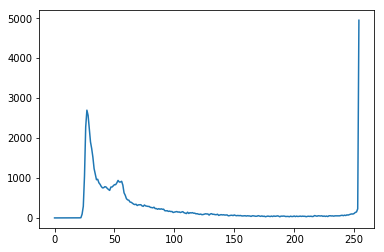

In [29]:
hists, bins=np.histogram(img_gray, 255, [0, 255])
plt.plot(hists)

ピークは3箇所で25と55と250。
25~55は暗めなので森や岩で、250~255はほぼ白なので雪か。

### 値を決めて雪部分の抽出を検討

2つのピークを分け、谷の一番深い位置と思われる `200` を閾値に設定

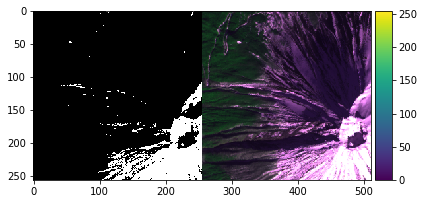

In [70]:
# 閾値処理
height, width= img_gray.shape
img_binary = np.zeros((height, width)) # 0で初期化
img_binary = img_gray > 200 # 閾値にもとづいて2値化

io.imshow(np.concatenate((color.gray2rgb(img_binary*255), img_natural), axis=1))

一番明るいところは抽出できているものの、日陰っぽくなっている雪らしき部分は全く抽出できず。

閾値を大きくずらして `80` に設定

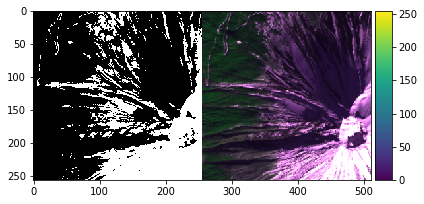

In [75]:
img_binary = np.zeros((height, width)) # 0で初期化
img_binary = img_gray > 80 # 閾値にもとづいて2値化
io.imshow(np.concatenate((color.gray2rgb(img_binary*255), img_natural), axis=1))

雪っぽい部分をそれなりに抽出できたか。

まだ右上の雪で日陰っぽい部分を救いきれていないので、 閾値をさらに下げて `40` に変更。

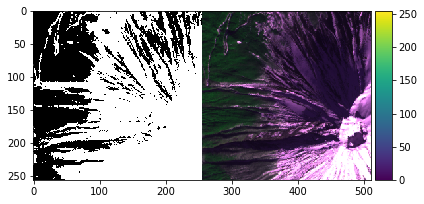

In [112]:
img_binary = np.zeros((height, width)) # 0で初期化
img_binary = img_gray > 40 # 閾値にもとづいて2値化
io.imshow(np.concatenate((color.gray2rgb(img_binary*255), img_natural), axis=1))

雪を全面カバーすることに成功した。が、左下の岩っぽい部分も誤ってカバーしてしまっている。グレースケール後の閾値判定ではこれくらいが限界らしい。

なお、Filter プラグインを用いることで、自動で閾値を設定して2値化することも可能。

閾値： 138


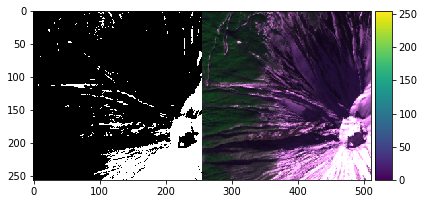

In [85]:
ret = filters.threshold_otsu(img_gray) #閾値を自動で判別
img_binary_auto = np.zeros((height, width))
img_binary_auto = img_gray > ret
io.imshow(np.concatenate((color.gray2rgb(img_binary_auto*255), img_natural), axis=1))
print("閾値：", ret)

## HSV画像による雪質判定

グレースケール以外に白っぽさを判定するために、HSV画像（色相・彩度・明度）の彩度と明度を利用してみる。

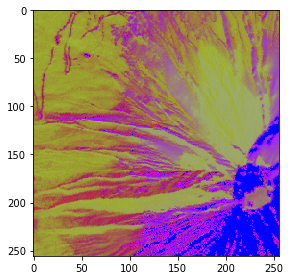

In [88]:
# RGB画像からHSV画像への変換
img_hsv = color.rgb2hsv(img_true)
io.imshow(img_hsv)

### 色相・彩度・明度をそれぞれ確認

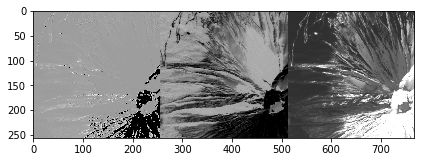

In [90]:
im_conb_hsv = np.concatenate(( img_hsv[:, :, 0],  img_hsv[:, :, 1], img_hsv[:,:,2]), axis=1)
io.imshow(im_conb_hsv)

ぱっと見で明度が利用できそうなため、明度について検証

ヒストグラムで明度の分布を確認

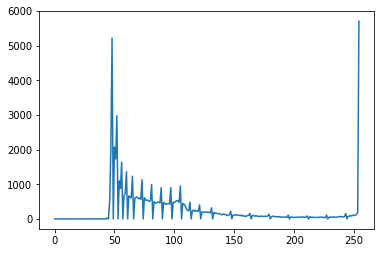

In [115]:
hists, bins=np.histogram(img_hsv[:,:,2]*255, 255, [0, 255])
plt.plot(hists)

 `color.rgb2hsv` を利用しているせいか変な周期はあるが、ピークを分けるように閾値設定

閾値150の場合

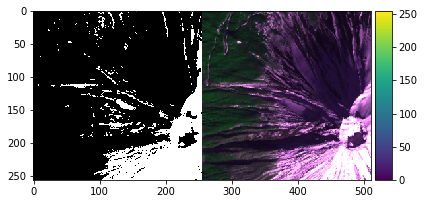

In [124]:
img_h = img_hsv[:,:,0]
img_s = img_hsv[:,:,1]
img_v = img_hsv[:,:,2]
# 閾値処理
height, width= img_h.shape
img_binary = np.zeros((height, width)) # 0で初期化
img_binary = img_v > 150 / 255 # 閾値にもとづいて2値化

io.imshow(np.concatenate((color.gray2rgb(img_binary*255), img_natural), axis=1))

100の山の左側に閾値を設定すべく、閾値を90に。

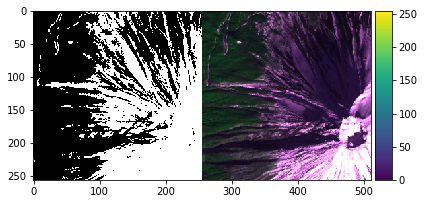

In [126]:
img_h = img_hsv[:,:,0]
img_s = img_hsv[:,:,1]
img_v = img_hsv[:,:,2]
# 閾値処理
height, width= img_h.shape
img_binary = np.zeros((height, width)) # 0で初期化
img_binary = img_v > 90 / 255 # 閾値にもとづいて2値化

io.imshow(np.concatenate((color.gray2rgb(img_binary*255), img_natural), axis=1))

In [ ]:
グレースケールよりも多少良さそうな雪の分類ができたか。

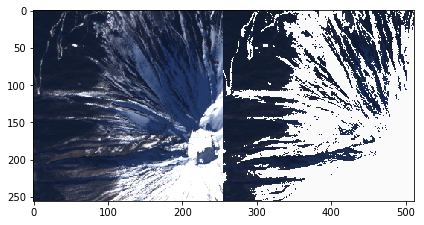

In [18]:
# 雪以外をマスキング
img_msk = img_true.copy()
img_msk[img_binary] = 0

#雪だけをマスキング
img_msk_rev = img_true.copy()
img_msk_rev[~img_binary] = 250

#img_msk_conb = np.concatenate((img_true[:, :, ], img_msk[:, :, ], img_msk_rev[:, :, ]),axis=1)
img_msk_conb = np.concatenate((img_true[:, :, ],img_msk_rev[:, :, ]),axis=1)
io.imshow(img_msk_conb)

### 以下、適当な検証

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


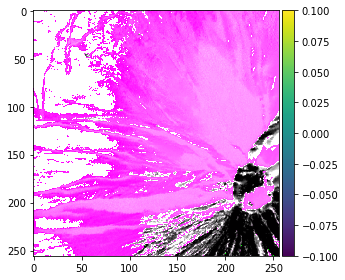

In [19]:
# NDSI（Normalized Difference Snow Index）を計算
img_band2 = imgs[6].copy()
img_band4 = imgs[8].copy()

img_NDSI = (img_band2 - img_band4) / (img_band2 + img_band4)  # 本当はband4ではなく5を使わなくてはいけないが5がない
# 最大最小を制限
#img_NDSI = np.clip(img_NDSI, 0, 255)

io.imshow(img_NDSI)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


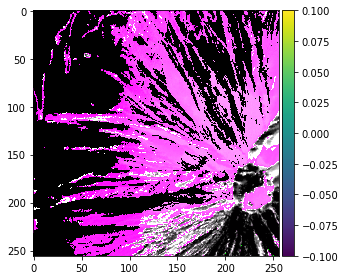

In [20]:
# #雪以外をマスキングした場合
img_NDSI_msk = img_NDSI.copy()
img_NDSI_msk[img_binary] = 0
io.imshow(img_NDSI_msk)

In [21]:
#雪部分をNDSIに変換
# img_msk = imgs[1].copy()
# img_msk[~img_binary] = img_NDSI[~img_binary]

# img_msk_conb = np.concatenate((img_msk[:, :, 0], img_msk[:, :, 2]),axis=1)
# io.imshow(img_msk_conb)
# #img_msk

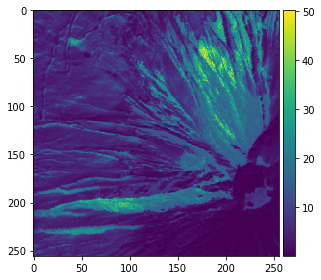

In [22]:
io.imshow(img_NDSI[:, :, 0])

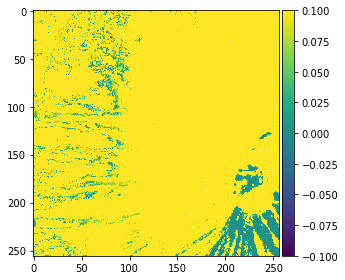

In [23]:
io.imshow(img_NDSI[:, :, 1])